In [1]:
import keras
keras.__version__

'2.13.1'

# Using word embeddings

This notebook contains the second code sample found in Chapter 6, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---


Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.

In [2]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [3]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80161 (313.13 KB)
Trainable params: 80161 (313.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6701 - acc: 0.6275 - val_loss: 0.6243 - val_acc: 0.6970
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5509 - acc: 0.7487 - val_loss: 0.5337 - val_acc: 0.7252
Epoch 3/10
625/625

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [11]:
import os

imdb_dir = 'D:\Data\\aclImdb_v1'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='gb18030', errors = 'ignore')
            # print("fname: ", fname)
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88583 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [16]:
glove_dir = 'D:\Data\glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), errors = 'ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 399913 word vectors.


In [25]:
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [23]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [24]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

### Define a model

We will be using the same model architecture as before:

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                320032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [27]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient update triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [28]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 148ms/step - loss: 1.4853 - acc: 0.5150 - val_loss: 0.7611 - val_acc: 0.5030
Epoch 2/10
7/7 [==============================] - 1s 122ms/step - loss: 0.6292 - acc: 0.6050 - val_loss: 1.3174 - val_acc: 0.5028
Epoch 3/10
7/7 [==============================] - 1s 119ms/step - loss: 0.6629 - acc: 0.6350 - val_loss: 0.6879 - val_acc: 0.5581
Epoch 4/10
7/7 [==============================] - 1s 121ms/step - loss: 0.5128 - acc: 0.6950 - val_loss: 0.8025 - val_acc: 0.5031
Epoch 5/10
7/7 [==============================] - 1s 125ms/step - loss: 0.5227 - acc: 0.7650 - val_loss: 0.9253 - val_acc: 0.4989
Epoch 6/10
7/7 [==============================] - 1s 117ms/step - loss: 0.3642 - acc: 0.8050 - val_loss: 0.6884 - val_acc: 0.5779
Epoch 7/10
7/7 [==============================] - 1s 120ms/step - loss: 0.1620 - acc: 0.9850 - val_loss: 1.5942 - val_acc: 0.5035
Epoch 8/10
7/7 [==============================] - 1s 120ms/step - loss: 0.2211 - acc: 0.89

Let's plot its performance over time:

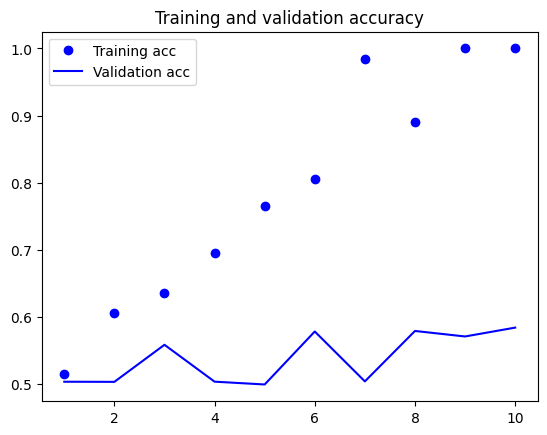

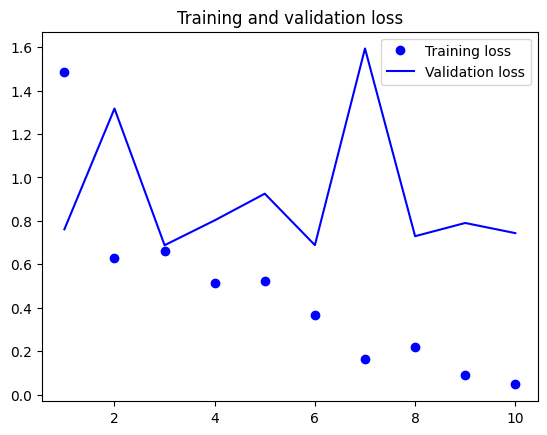

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [47]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 200  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 87396 unique tokens.
Shape of data tensor: (25000, 200)
Shape of label tensor: (25000,)


In [41]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 100)          1000000   
                                                                 
 flatten_7 (Flatten)         (None, 20000)             0         
                                                                 
 dense_13 (Dense)            (None, 32)                640032    
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1640065 (6.26 MB)
Trainable params: 1640065 (6.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 196ms/step - loss: 0.6983 - acc: 0.5050 - val_loss: 0.7005 - val_acc: 0.5015
Epoch 2/10
7/7 [==

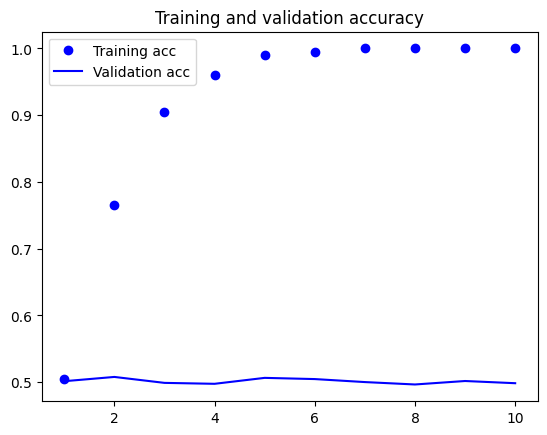

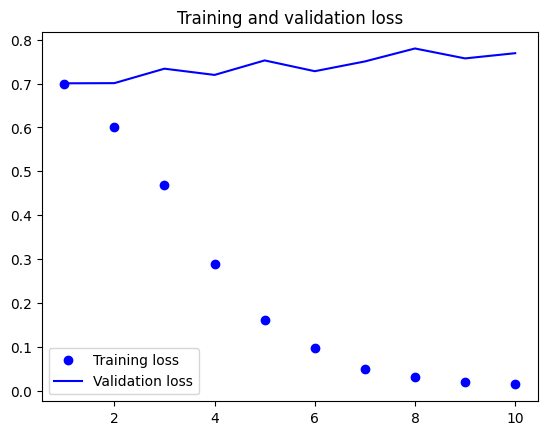

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [45]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), errors = 'ignore')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [48]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

ValueError: Cannot assign value to variable ' dense_13/kernel:0': Shape mismatch.The variable shape (20000, 32), and the assigned value shape (10000, 32) are incompatible.

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!